# Data Collection From Net Unicorn Into snl-server-5

## Import Dependencies

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import pandas as pd
import subprocess
import os
import dotenv

import matplotlib.pyplot as plt

from netunicorn.client.remote import RemoteClient, RemoteClientException
from netunicorn.base import Experiment, ExperimentStatus, Pipeline
from netunicorn.library.tasks.capture.tcpdump import StartCapture, StopNamedCapture
from netunicorn.library.tasks.upload.fileio import UploadToFileIO
from netunicorn.library.tasks.upload.webdav import UploadToWebDav
from netunicorn.library.tasks.basic import SleepTask
from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTest
from netunicorn.library.tasks.video_watchers.youtube_watcher import WatchYouTubeVideo
from netunicorn.library.tasks.video_watchers.vimeo_watcher import WatchVimeoVideo
from netunicorn.library.tasks.video_watchers.twitch_watcher import WatchTwitchStream
from netunicorn.base import DockerImage

from collections import defaultdict
from scapy.layers.inet import IP, TCP
from scapy.all import rdpcap

from math import ceil

from collections import defaultdict

In [3]:
#Private.env file used to store private variables such as filepaths and Ip address
dotenv.load_dotenv('Private.env')

True

## Capture Videos Reference (Created in DataCollection.ipynb)

- For reference use only here
- All Captures are Stored in folders labeled capture_#, defined in the next cell (on snl server)
- Descriptions of each capture we took with videos, # nodes, # seconds, # loops, run #, and node name (if applicable)
- Stored in snl-server-5.cs.ucsb.edu:/mnt/md0/cs190n/team_dn/capture_<#>/ 

In [4]:
"""
#capture_0 10 node
video_links = {
    'video0': 'https://www.youtube.com/watch?v=_KOpmohOznIiU',
    'video1': 'https://www.youtube.com/watch?v=BGqfVOc_Rl4',
    'video2': 'https://www.youtube.com/watch?v=XVO9CS8D4hQ',
    'video3': 'https://www.youtube.com/watch?v=sYc1MsexWKE',
    'video4': 'https://www.youtube.com/watch?v=KQwPyhcidUE',
    'video5': 'https://www.youtube.com/watch?v=_BPexIx58Zg',
    'video6': 'https://www.youtube.com/watch?v=MbHIxbbyOi8',
    'video7': 'https://www.youtube.com/watch?v=gKCScoG83SA',
    'video8': 'https://www.youtube.com/watch?v=w9iFuKzfoIs',
    'video9': 'https://www.youtube.com/watch?v=slwVFwPjUx4',
}

#capture_1 15 nodes
video_links = {
    'video0': 'https://www.youtube.com/watch?v=vkfTSlTnaBQ',
    'video1': 'https://www.youtube.com/watch?v=KT1-JQTiZGc',
    'video2': 'https://www.youtube.com/watch?v=_38JDGnr0vA',
}


#capture_2 50 nodes videos >5 min(Did not get all videos/nodes)
video_links = {
    'video0': 'https://www.youtube.com/watch?v=vkfTSlTnaBQ',
    'video1': 'https://www.youtube.com/watch?v=KT1-JQTiZGc',
    'video2': 'https://www.youtube.com/watch?v=_38JDGnr0vA',
    'video3': 'https://www.youtube.com/watch?v=GqulwE_yKww',
    'video4': 'https://www.youtube.com/watch?v=v2WCnF3SSUE',
    'video5': 'https://www.youtube.com/watch?v=hif5eI5pBxo',
    'video6': 'https://www.youtube.com/watch?v=0e4qRdlfJcs',
    'video7': 'https://www.youtube.com/watch?v=aIovmgzyuL0',
    'video8': 'https://www.youtube.com/watch?v=k7cGyYaxUnI',
    'video9': 'https://www.youtube.com/watch?v=4GL-X4LqfVc',
}


#capture_3 (Redoing 2 but with 40 nodes) videos > 5 min
video_links = {
    'video0': 'https://www.youtube.com/watch?v=vkfTSlTnaBQ',
    'video1': 'https://www.youtube.com/watch?v=KT1-JQTiZGc',
    'video2': 'https://www.youtube.com/watch?v=_38JDGnr0vA',
    'video3': 'https://www.youtube.com/watch?v=GqulwE_yKww',
    'video4': 'https://www.youtube.com/watch?v=v2WCnF3SSUE',
    'video5': 'https://www.youtube.com/watch?v=hif5eI5pBxo',
    'video6': 'https://www.youtube.com/watch?v=0e4qRdlfJcs',
    'video7': 'https://www.youtube.com/watch?v=aIovmgzyuL0',
    'video8': 'https://www.youtube.com/watch?v=k7cGyYaxUnI',
    'video9': 'https://www.youtube.com/watch?v=4GL-X4LqfVc',
}

#capture_4 switching to vimeo 60 seconds, 20 nodes
#  second run vimeo 60 seconds, 30 nodes
#    TOTAL capture_4 = 50 nodes, 60 seconds

video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
 
}

#capture_5 Vimeo 60 seconds, 6 nodes, to determine preprocessing steps
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
}

#capture_6 Vimeo 60 seconds,  (oops)
# raspi-e4:5f:01:a0:34:a8
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
}


#capture_7 Vimeo 60 seconds, 1 nodes, looped 25 times (NIK)
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
}

#capture_8 Vimeo 60 seconds, 1 nodes, looped 50 times (Dakota) from 'raspi-e4:5f:01:ac:e3:80' node
video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
}
"""
#capture_9 DEMONSTRATION CAPTURE , Vimeo 60 seconds, 5 nodes, 1 loops (total 50 .pcap files)
# Second watch Vimeo 60 seconds, 2 nodes, 2 loops (total 20 .pcap files)

video_links = {
    'video0': 'https://vimeo.com/872245830',
    'video1': 'https://vimeo.com/249226357',
    'video2': 'https://vimeo.com/250383662',
    'video3': 'https://vimeo.com/255370388',
    'video4': 'https://vimeo.com/259411563',
}



# Data Pre-Processing

In [5]:
# Used to recursively search through snl directory and find all pcap files and return them in list
# Example input = '/mnt/md0/cs190n/team_dn/capture_0'
def get_all_pcap_files(base_input_directory):
    all_pcap_files = []
    for root, dirs, files in os.walk(base_input_directory):
        for file_name in files:
            if file_name.endswith(".pcap"):
                full_path = os.path.join(root, file_name)
                all_pcap_files.append(full_path)
                
    return all_pcap_files


# Takes input of pcap file, then returns the label (Assuming the label is in first part of word) 
#    - Correct Labeling structure is defined in pipeline in DataCollection by variables so should be uniform
# Example input = /mnt/md0/cs190n/team_dn/capture_0/27f89405-f1ca-4642-991b-0f71f8e0faab/tmp/video0.pcap
# will return video0, to be used as a label

# input video0_1.pcap , or just video0.pcap
# output video0

def extract_video_name(pcap_path):
    base_name = os.path.basename(pcap_path)
    possible_name = base_name.split('.')[0]
    if '_' in possible_name:
        name = base_name.split('_')[0]
    else:
        name = possible_name
    
    return name


# fucntion that will take in a pcap stream and place into a dataframe with columns for up_bps, down_bps ....
# the rows will be each time interval(index) defined in interval_float
# also returns the label for the dataFrame
def pcap_to_df(pcap_path, src_ip, interval_float=0.25):
    packets = rdpcap(pcap_path)
     # Check if the pcap file is empty
    if not packets:
        print(f"No packets found in {pcap_path}. Returning an empty DataFrame.")
        return pd.DataFrame(), None
    
    interval = str(f"{interval_float}S")
    # Initialize data structures
    
    data = defaultdict(lambda: {'up_bps': 0, 'down_bps': 0, 'up_pps': 0, 'down_pps': 0, 'up_plen': 0, 'down_plen': 0})
    start_time = packets[0].time

    # Process packets
    for packet in packets:
        if IP in packet and TCP in packet:
            # Calculate time offset
            current_time = packet.time
            chunk_key = int((current_time - start_time) // interval_float)
            
            # Determine direction and accumulate data
            direction = 'up' if packet[IP].src == src_ip else 'down'
            data[chunk_key][f'{direction}_bps'] += len(packet)
            data[chunk_key][f'{direction}_pps'] += 1
            data[chunk_key][f'{direction}_plen'] += len(packet)

    if not data:
        print(f"No relevant packet data found in {pcap_path}.")
        return pd.DataFrame(), None       
    
    last_chunk = max(data.keys())
    first_chunk = min(data.keys())

    # Ensure every interval from the first actual data chunk to the last has an entry
    for time_chunk in range(first_chunk, last_chunk + 1):
        if time_chunk not in data:
            data[time_chunk] = {'up_bps': 0, 'down_bps': 0, 'up_pps': 0, 'down_pps': 0, 'up_plen': 0, 'down_plen': 0}
       
    df_data = []
    
    #Relabel DataFrame to Start at 0 and increment in interval
    time_offset = first_chunk * interval_float
    for time_chunk in sorted(data.keys()):
        chunk_data = data[time_chunk]
        chunk_data['time'] = (time_chunk * interval_float) - time_offset
        df_data.append(chunk_data)

    df = pd.DataFrame(df_data)
    df.set_index('time', inplace=True)
    
    row_label = extract_video_name(pcap_path)
    
    return df, row_label

#fuction that takes in pcap and returns a row with data points of bps_all agregated into interval_float for columns
#returns the label for the row which can be appended later if needed
#NOT USED IN CURRENT VERSION
def pcap_to_bps_row(pcap_path, src_ip, interval_float=0.25):
    packets = rdpcap(pcap_path)
    start_time = packets[0].time
    end_time = packets[-1].time
    total_duration = end_time - start_time

    # Calculate the total number of intervals
    total_intervals = ceil(total_duration / interval_float)
    #print(f"TOTAL DURATION: {total_duration}")
    #print(f"TOTAL INTERVALS: {total_intervals}")

    # Initialize data structures for bits per interval
    bits_per_interval = defaultdict(int)

    # Initialize each interval with 0 bps
    for i in range(total_intervals):
        bits_per_interval[i] = 0

    # Process packets
    for packet in packets:
        if IP in packet and TCP in packet:
            current_time = packet.time
            interval_key = int((current_time - start_time) // interval_float)
            bits_per_interval[interval_key] += len(packet) * 8  # Convert bytes to bits

    # Calculate bps for each interval
    bps_per_interval = {key: bits / interval_float for key, bits in bits_per_interval.items()}

    # Create a single row with calculated bps values for each time interval
    sorted_intervals = sorted(bps_per_interval.keys())
    row_data = [bps_per_interval[interval] for interval in sorted_intervals]
    row_label = extract_video_name(pcap_path)

    return row_data, row_label


## Turning .pcaps into DataFrames

- First recursively obtains all all the .pcaps in the root_dir (obtained through netUnicorn DataCollection.ipynb placed on snl-server-5)
- Determine your constants. 
- burst_interval: For the scklearn classifier used 5 seconds, pyTorch CNN we used .25 seconds
- Each Video is Turned into 1 entire Dataframe
- List of Dataframes is stored in raw_video_dfs and with their labels

In [6]:
root_dir = f"{os.getenv('SNL_SERVER_PATH')}capture_9"   # Where to retrieve the .pcap files
current_ip = os.getenv('NODE_IP')                       # Determine which flow to take packets from
burst_interval = 5                                      # Use to aggregate data into intervals
capture_time = 60                                       # Time to crop video packets
intervals_per_row = int(capture_time / burst_interval)  # 30 seconds / 0.25 seconds per interval

# Get all PCAP files in the directory specified in the pipeline, or chosen
all_pcap_files = get_all_pcap_files(root_dir)
print(f"Obtained {len(all_pcap_files)} .pcap Files")  

# Lists which are populated by pcap_to_df function
raw_video_dfs = []
labels = []

#Iterate through each PCAP and turn it into df, add to raw_videos_dfs and label to labels
for count, pcap_file in enumerate(all_pcap_files):
    cur_df, cur_label = pcap_to_df(pcap_file, current_ip, burst_interval)
    raw_video_dfs.append(cur_df)
    labels.append(cur_label)
    count += 1
    print(f"Process PCAP #{count}")

Obtained 25 .pcap Files
Process PCAP #1
Process PCAP #2
Process PCAP #3
Process PCAP #4
Process PCAP #5
Process PCAP #6
Process PCAP #7
Process PCAP #8
Process PCAP #9
Process PCAP #10
Process PCAP #11
Process PCAP #12
Process PCAP #13
Process PCAP #14
Process PCAP #15
Process PCAP #16
Process PCAP #17
Process PCAP #18
Process PCAP #19
Process PCAP #20
Process PCAP #21
Process PCAP #22
Process PCAP #23
Process PCAP #24
Process PCAP #25


## Normalize Video DataFrames

In [7]:
#Stores a list of each normalized youtube video (DataFrame) for pyTorch CNN (3 Dimensions)
video_dfs = []

#Crop all dataframes(1 video each) to same length and remove any short captures
for df, label in zip(raw_video_dfs, labels):
    # Truncate or pad the DataFrame
    if len(df) > intervals_per_row:
        df = df.iloc[:intervals_per_row+1].copy()
        df['video'] = label
        video_dfs.append(df)
    else:
        print("Packet To Short, Removing from DataFrame List")

print("Created Videos DataFrame")        
print(f"Total Successful DFs: {len(video_dfs)}")   

# Create a concated dataframe for the Sklearn model (2D array) by combining all video_dfs(3D)
videos_concat = pd.concat(video_dfs, ignore_index=False)


#TIME SAVER: Import concat dataframe to CSV So No Need To Recompute
csv_filepath = f'{root_dir}_{burst_interval}_{capture_time}'
videos_concat.to_csv(csv_filepath, index=True)
print("Saved To CSV File")
videos_concat = pd.read_csv(csv_filepath, index_col=None)


Created Videos DataFrame
Total Successful DFs: 25
Saved To CSV File


In [8]:
print(videos_concat)

     time  up_bps  down_bps  up_pps  down_pps  up_plen  down_plen   video
0       0    2296      7851      18        14     2296       7851  video4
1       5   40393   2597882     312       496    40393    2597882  video4
2      10   55042   7160422     441      1112    55042    7160422  video4
3      15   40340   2315365     196       355    40340    2315365  video4
4      20    6114   2306281      70       261     6114    2306281  video4
..    ...     ...       ...     ...       ...      ...        ...     ...
320    40   15624   1173588     155       831    15624    1173588  video3
321    45   12592   1482076     168      1035    12592    1482076  video3
322    50   12756   1608305     162      1134    12756    1608305  video3
323    55   23617   2197883     269      1546    23617    2197883  video3
324    60   65787   6703728     927      4669    65787    6703728  video3

[325 rows x 8 columns]


## View Video DataFrames

In [9]:
# Graphing Functions to Help Visualize Data Collection

import matplotlib.pyplot as plt
import itertools

def plot_multiple_streams(df, num_rows):
    """
    Plots multiple time series (rows) from the DataFrame on the same graph as line plots.

    :param df: DataFrame containing the data.
    :param num_rows: Number of rows (time series) to plot.
    """
    num_rows = min(num_rows, len(df))
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    plt.figure(figsize=(12, 6))

    # Plot each row as a separate line plot
    for i in range(num_rows):
        plt.plot(df.columns, df.iloc[i], linestyle='-', marker='o', color=next(color_cycle), label=f'Video {i+1}')

    plt.title('PPS Flow of Multiple YouTube Video Streams')
    plt.xlabel('Time Intervals')
    plt.ylabel('Average PPS')
    plt.xticks(rotation=45)
    plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    plt.show()
    
def plot_time_series(df, column, title='Time Series Plot', ylabel=None):
    """
    Plots a time series from a DataFrame.

    Parameters:
    df (DataFrame): The resampled DataFrame.
    column (str): The name of the column to plot.
    title (str, optional): The title of the plot. Defaults to 'Time Series Plot'.
    ylabel (str, optional): The label for the y-axis. Defaults to the same as the column name.
    """

    if ylabel is None:
        ylabel = column

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label=column)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

import matplotlib.pyplot as plt

def plot_time_series_dfs(dataframes, column_label, feature_label, title_string):
    """
    Plot line graphs for a specific column from a list of dataframes on the same plot.

    Parameters:
    dataframes (list of pd.DataFrame): List of dataframes to plot.
    column_label (str): The column label to plot from each dataframe.
    """
    plt.figure(figsize=(10, 6))

    for df in dataframes:
        if column_label in df.columns:
            plt.plot(df.index, df[column_label], label=df[column_label].name)
        else:
            print(f"Column '{column_label}' not found in one of the dataframes.")

    plt.xlabel('Time')
    plt.ylabel(column_label)
    plt.title(f'Time Series Plot for {feature_label} {column_label} on {title_string}')
    plt.legend()
    plt.show()


### Graph Structures
- View Every Capture Stream Per Video with selected feature, all in one graph

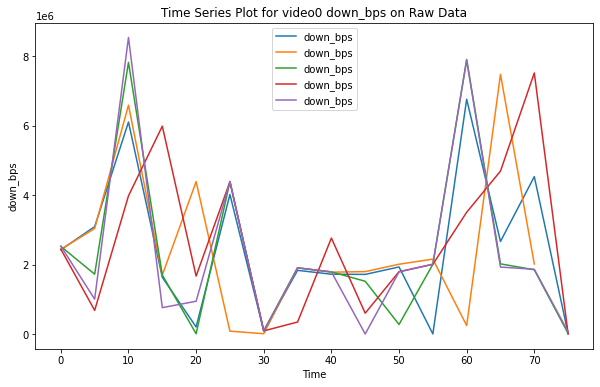

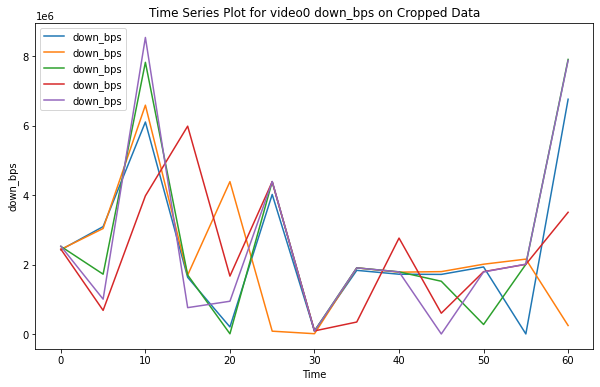

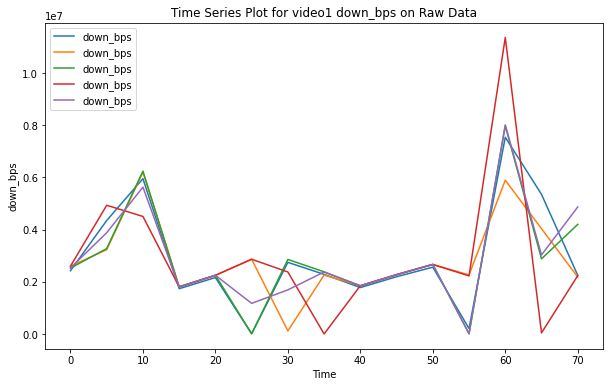

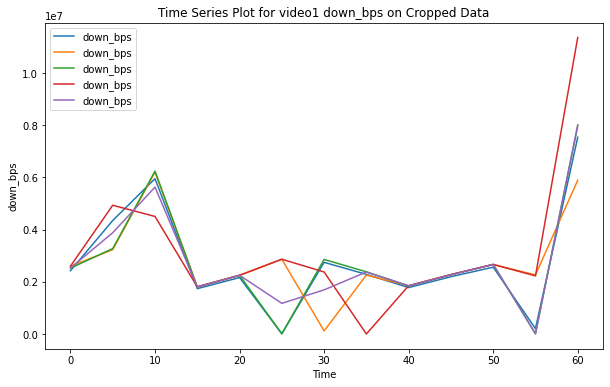

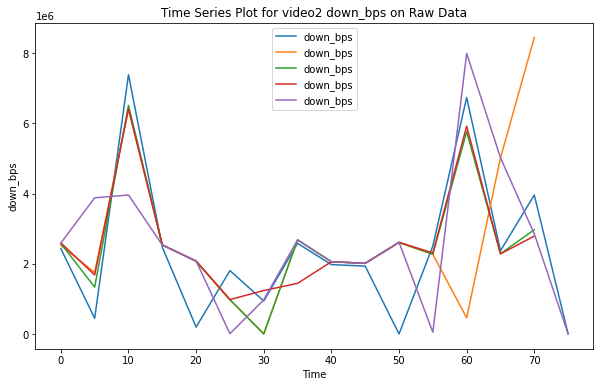

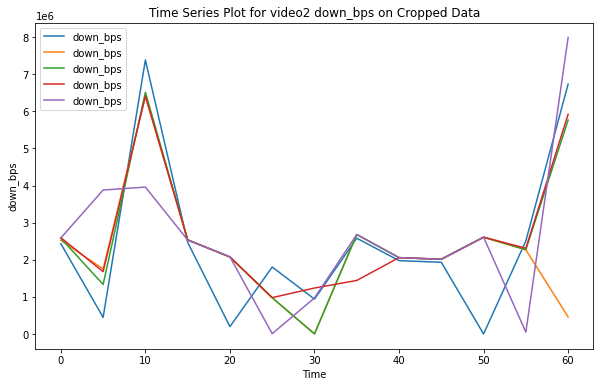

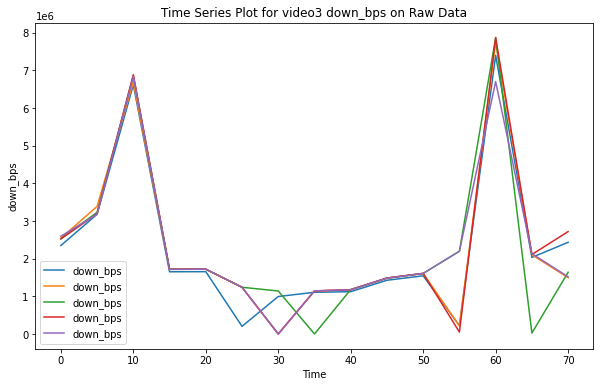

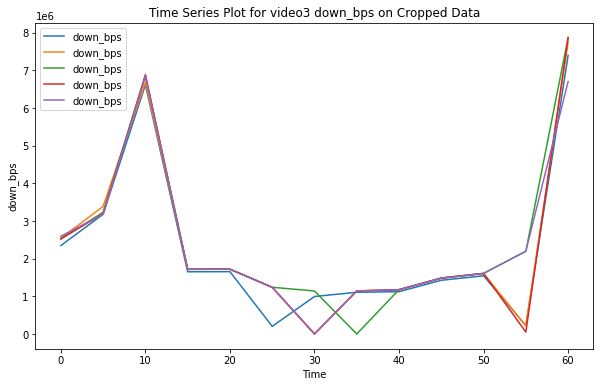

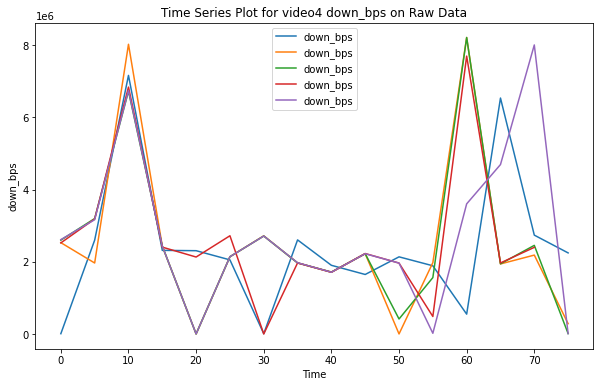

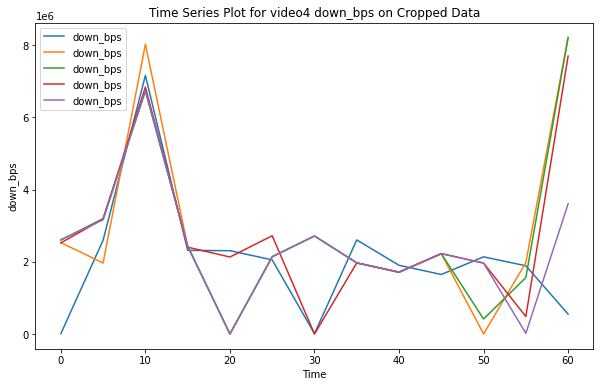

In [10]:
# data[time_chunk] = {'up_bps': 0, 'down_bps': 0, 'up_pps': 0, 'down_pps': 0, 'up_plen': 0, 'down_plen': 0}
unique_labels = sorted(set(labels))
feature = 'down_bps'
for label in unique_labels:
    feature_raw_dfs = [df for df, l in zip(raw_video_dfs, labels) if l == label]
    plot_time_series_dfs(feature_raw_dfs, feature, label, 'Raw Data')
    
    feature_processed_dfs = [df for df, l in zip(video_dfs, labels) if l == label]
    plot_time_series_dfs(feature_processed_dfs, feature, label, 'Cropped Data')


# Classifier Model Training

In [22]:
%pip install scikit-learn
%pip install tensorflow
%pip install trustee

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from trustee import ClassificationTrustee



Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pi

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


## PyTorch Convolutional Neural Network
- Take in video_dfs which is a list of dataFrames, where each dataframe is one video
- Is able to view connections between timeframes, which the RandomForestClassifier can not do (3D vs 2D)

In [23]:
#CNN uses the video_dfs that are created in the Normalize Video DataFrames Cells
# DATA IS NOT STORED ON SNL-SERVER, HAS TO BE PROCESSED TO BE RUN
# EXAMPLE WITH EXAMPLE 
# Prepare the data
X_list = []
y_list = []

for df in video_dfs:
    # Assuming the label is in the last column
    X_list.append(df.iloc[:, :-1].values)  # Features
    y_list.append(df.iloc[0, -1])  # Label (assuming all rows in a DF have the same label)

# Convert lists to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

# Reshape X for CNN input (samples, time segments, features, 1)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=45)

# Create the CNN model
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=30, batch_size=32)

# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100}%")

Epoch 1/30
1/1 [==============================] - 1s 626ms/step - loss: 642660.9375 - accuracy: 0.1765
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 312139.0625 - accuracy: 0.2353
Epoch 3/30
1/1 [==============================] - 0s 8ms/step - loss: 319280.2500 - accuracy: 0.1765
Epoch 4/30
1/1 [==============================] - 0s 9ms/step - loss: 238856.0000 - accuracy: 0.2941
Epoch 5/30
1/1 [==============================] - 0s 10ms/step - loss: 215214.4219 - accuracy: 0.2353
Epoch 6/30
1/1 [==============================] - 0s 9ms/step - loss: 138263.3594 - accuracy: 0.4706
Epoch 7/30
1/1 [==============================] - 0s 8ms/step - loss: 118212.2656 - accuracy: 0.3529
Epoch 8/30
1/1 [==============================] - 0s 10ms/step - loss: 139400.4531 - accuracy: 0.1176
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 130887.2188 - accuracy: 0.1765
Epoch 10/30
1/1 [==============================] - 0s 9ms/step - loss: 94916.3125 - ac

## Sklearn RandomForestClassifier

In [24]:
#Function to train a Random Forest Classifier on a Dataframe
#Has the option to print_report from sklearn, or print_trustee_report which is to print the trustee report 
def Random_Forest_Classifier(df,print_report=False, print_trustee_report=False):

    X = df.drop('video', axis=1)  # Features from DataFrame
    y = df['video']  # Labels from your existing array

    # Split the dataset into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create and train the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy or other performance metric
    accuracy = accuracy_score(y_test, y_pred)
    
    if print_report:
        print(classification_report(y_test, y_pred))
        
    if print_trustee_report:
        trustee = ClassificationTrustee(expert=clf)
        trustee.fit(X_train, y_train, num_samples=len(X_train) // 2, num_iter=20, train_size=0.99)

        # Display Trustee Results
        _, dt, _, score = trustee.explain()
        print(f"Training score of pruned DT: {score}")
        dt_y_pred = dt.predict(X_train)
        print("Model explanation global fidelity report:")
        print(metrics.classification_report(clf.predict(X_train), dt_y_pred))
        print("Model explanation score report:")
        print(metrics.classification_report(y_train, dt_y_pred))

        # plot a tree
        fig = plt.figure(figsize=(25,20))
        plot_tree(dt, feature_names=X_train.columns, class_names=sorted(videos_concat['video'].unique()), filled=True, max_depth=5)


    return accuracy

### View Overall Results for Concated Dataframe, as well as the individual accuracy per time frame

In [28]:
#TIME SAVER: Obtain dataframe from CSV so no need to preprocess data every use (Keep Commented Unless Used)

csv_name = 'capture_8_5s_concat2.csv'       # Looking At One Node Classifier       (5 vidoes, 50 watcher per video)
#csv_name = 'capture_4_5s_concat2.csv'       # Looking At Multiple Node Classifier  (5 vidoes, 50 watcher per video)

videos_concat = pd.read_csv(f"{os.getenv('SNL_SERVER_PATH')}{csv_name}", index_col=None)

print("COMBINED TIME FRAME ACCURACY REPORT")

#Print The Report for the OverAll Concat Dataframe accuracy (average of all timeframe accuracies)
Random_Forest_Classifier(videos_concat, print_report=True)

#Print all the interval accuracy's in the videos_concat, then keep track of the best one to use in Trustee
best_accuracy = 0
best_df = None
best_time = None
print("INDIVIDUAL TIME FRAME ACCURACY REPORT")
unique_times = videos_concat['time'].unique()
for time in unique_times:
    df = videos_concat[videos_concat['time'] == time].reset_index(drop=True)
    accuracy = Random_Forest_Classifier(df)
    print(f"Time: {time}, Accuracy: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_df = df
        best_time = time

print()        
print(f"Best Time: {best_time}, Best Accuracy: {best_accuracy}")



COMBINED TIME FRAME ACCURACY REPORT
              precision    recall  f1-score   support

      video0       0.68      0.60      0.64       130
      video1       0.68      0.66      0.67       127
      video2       0.66      0.66      0.66       155
      video3       0.64      0.62      0.63       116
      video4       0.52      0.63      0.57       113

    accuracy                           0.63       641
   macro avg       0.64      0.63      0.63       641
weighted avg       0.64      0.63      0.64       641

INDIVIDUAL TIME FRAME ACCURACY REPORT
Time: 0, Accuracy: 0.2777777777777778
Time: 5, Accuracy: 0.2962962962962963
Time: 10, Accuracy: 0.48148148148148145
Time: 15, Accuracy: 0.8703703703703703
Time: 20, Accuracy: 0.7222222222222222
Time: 25, Accuracy: 0.5925925925925926
Time: 30, Accuracy: 0.6666666666666666
Time: 35, Accuracy: 0.9074074074074074
Time: 40, Accuracy: 0.9444444444444444
Time: 45, Accuracy: 0.9074074074074074
Time: 50, Accuracy: 0.8518518518518519
Time: 55,

## Trustee Model Evaluation RandomForestClassifier 

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

      video0       0.87      0.91      0.89        22
      video1       0.94      0.75      0.83        20
      video2       0.89      1.00      0.94        34
      video3       0.92      0.96      0.94        23
      video4       1.00      0.92      0.96        25

    accuracy                           0.92       124
   macro avg       0.92      0.91      0.91       124
weighted avg       0.92      0.92      0.92       124

Model explanation score report:
              precision    recall  f1-score   support

      video0       0.87      0.91      0.89        22
      video1       0.94      0.75      0.83        20
      video2       0.89      1.00      0.94        34
      video3       0.92      0.96      0.94        23
      video4       1.00      0.92      0.96        25

    accuracy                           0.92       124
   macro avg       0.92 

/home/dakotabarnes/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.9444444444444444

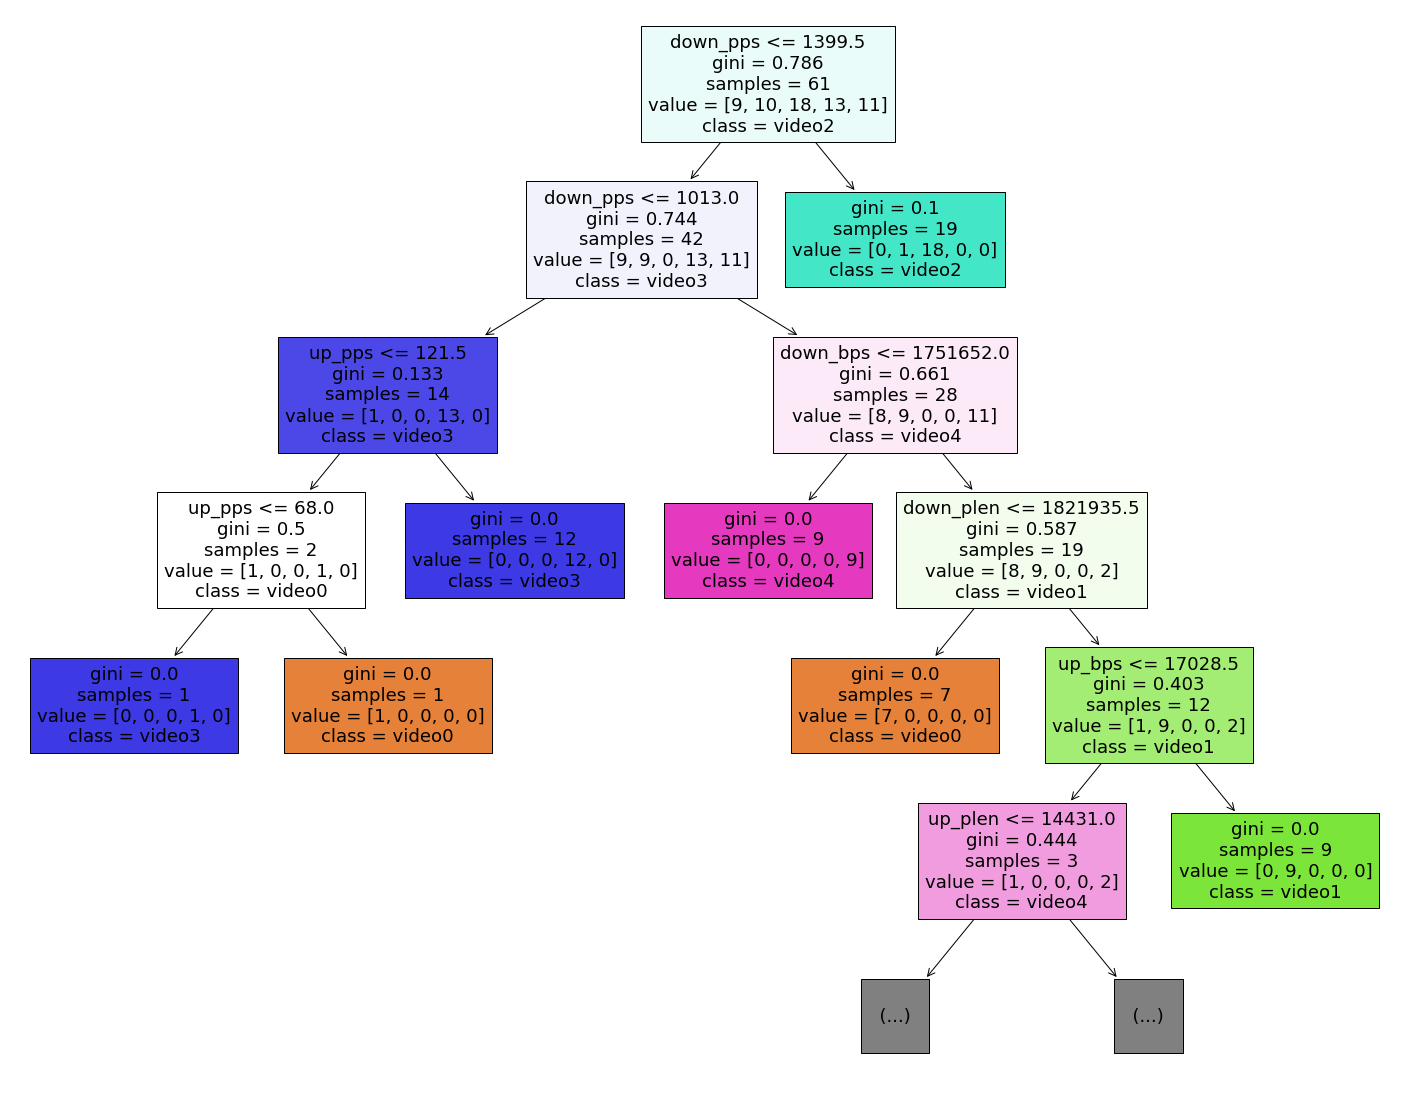

In [29]:
#Run the Trustee Visualization Report on the Best Preforming time frame to visualize the choices that are being made
Random_Forest_Classifier(best_df, print_trustee_report=True)

In [30]:
###### BEEEEEEEEEEP (To know when finished)

from IPython.display import Audio, display

def play_beep():
    framerate = 44100
    duration = 1  # in seconds
    frequency = 500  # Hz, standard A4 tone

    t = np.linspace(0, duration, int(framerate * duration))
    audio_data = np.sin(2 * np.pi * frequency * t)

    display(Audio(audio_data, rate=framerate, autoplay=True))

# Play beep when the code finishes
play_beep()
